In [16]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import sys
from sklearn.model_selection import KFold
sys.path.append('C:/Users/w37262do/Documents/git/PyIR/src') # todo
from pyir_spectralcollection import PyIR_SpectralCollection as pir
import pyir_pca as pir_pca

In [17]:
# Experiment
is_local = True # todo
seed = 0 if is_local else int(sys.argv[-1])
np.random.seed(seed=seed)
balanced = True
even_or_odd = "even" if balanced else "odd" 
annotation_class_colors = np.array([[0,255,0],[128,0,128],[255,0,255],[0,0,255],[255,165,0],[255,0,0]])
annotation_class_names = np.array(['epithelium_n','stroma_n','epithelium_c','stroma_c','corpora_amylacea','blood'])

In [18]:
kit = pir()
n_comp=30
def preprocess_0(spectra, wavenumbers,mean=None,loadings=None,pre=False):
    if pre: return spectra,wavenumbers
    
    temp_pca = pir_pca.PyIR_PCA()
    spectra = temp_pca.pca_smoothing(spectra,mean,loadings,n_comp=n_comp)
    return spectra, wavenumbers

def preprocess_1(spectra, wavenumbers,mean=None,loadings=None,pre=False):
    spectra, wavenumbers = kit.remove_range(1360,1490, spectra, wavenumbers)
    spectra = kit.all_spec_min2zero(spectra)
    spectra = kit.vector_norm(spectra)
    if pre: return spectra,wavenumbers
    temp_pca = pir_pca.PyIR_PCA()
    spectra = temp_pca.pca_smoothing(spectra,mean,loadings,n_comp=n_comp)
    return spectra, wavenumbers

def preprocess_2(spectra, wavenumbers,mean=None,loadings=None,pre=False):
    spectra, wavenumbers = kit.remove_range(1360,1490, spectra, wavenumbers)
    spectra = kit.all_spec_min2zero(spectra)
    spectra = kit.vector_norm(spectra)
    if pre: return spectra,wavenumbers
    temp_pca = pir_pca.PyIR_PCA()
    spectra = temp_pca.pca_smoothing(spectra,mean,loadings,n_comp=n_comp)
    spectra, wavenumbers = kit.data_deriv(spectra, wavenumbers, 21, 5, 1)
    return spectra, wavenumbers

def preprocess_3(spectra, wavenumbers,mean=None,loadings=None,pre=False):
    spectra, wavenumbers = kit.remove_range(1360,1490, spectra, wavenumbers)
    spectra = kit.all_spec_min2zero(spectra)
    spectra = kit.vector_norm(spectra)
    if pre: return spectra,wavenumbers
    temp_pca = pir_pca.PyIR_PCA()
    spectra = temp_pca.pca_smoothing(spectra,mean,loadings,n_comp=n_comp)
    spectra, wavenumbers = kit.data_deriv(spectra, wavenumbers, 21, 5, 2)
    return spectra, wavenumbers

pipelines = [
    preprocess_0,
    preprocess_1,
    preprocess_2,
    preprocess_3, # todo
]

In [19]:
spectra = np.load(f"./data/data_{even_or_odd}.npy") # todo
labels = np.load(f"./data/labels_{even_or_odd}.npy") # todo
pids = np.load(f"./data/pids_{even_or_odd}.npy") # todo
wavenumbers = np.load("./data/wavenumbers.npy") # todo
print(f"Assembled data with {len(spectra)} samples and {len(labels)} labels and {len(pids)} pids and {len(wavenumbers)} wavenumbers")

Assembled data with 100096 samples and 100096 labels and 100096 pids and 425 wavenumbers


## Run experiment for every pipeline

In [20]:
def train_model(train_data, train_labels):
    rf_model = Pipeline([
        ("normalise",StandardScaler(),),
        ("randomforest",RandomForestClassifier(n_estimators=500, min_samples_leaf=10))
    ])
    rf_model.fit(train_data, train_labels)
    return rf_model

def test_model(model, test_data, test_labels, dataset_name = None):
    pred = model.predict(test_data)
    acc = accuracy_score(test_labels, pred)
    f1m = f1_score(test_labels, pred, average='macro')
    f1 = f1_score(test_labels, pred, average=None)
    print(f"\t{dataset_name} | OA: {acc:.4f} | f1: {f1m:.4f}")
    return acc,f1m,f1

Text(0.5, 1.0, 'mean raw spectra per-class')

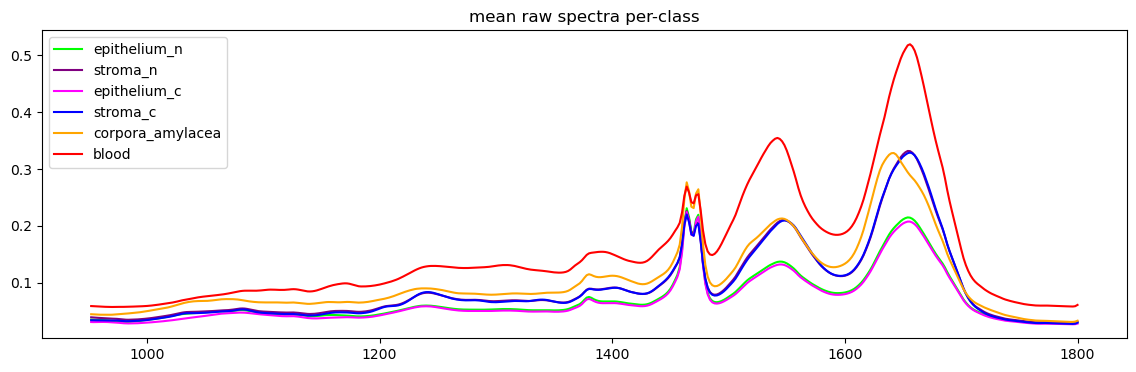

In [21]:
fig,ax = plt.subplots(figsize=(14,4))
for cls in range(len(annotation_class_names)):
    ax.plot(
        wavenumbers,
        np.mean(spectra[np.where(labels == cls)], axis=0),
        color=annotation_class_colors[cls]/255.0,
        label=annotation_class_names[cls]
    )
ax.legend()
ax.set_title("mean raw spectra per-class")

In [22]:
for t_idx in range(0, len(pipelines)):
    ### PROCESS SPECTRA ACCORDING TO CURRENT PIPELINE
    pre_spectra, pre_wavenumbers = pipelines[t_idx](spectra,wavenumbers,pre=True)
    #processed_spectra,processed_wavenumbers = pipelines[t_idx](spectra, wavenumbers)
       
    ### RUN K-FOLD SPLIT
    kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
    unique_pids = np.unique(pids)
    accs = []
    f1ms = []
    f1s = []
    for i, (train_pids, test_pids) in enumerate(kfold.split(unique_pids)):
        where_train = np.where(np.isin(pids,unique_pids[train_pids]))[0]
        where_test = np.where(np.isin(pids,unique_pids[test_pids]))[0]
        
        ### CALCULATE PCA MEAN AND LOADINGS
        pca = PCA(n_components=n_comp)
        pca.fit(pre_spectra[where_train])
        pca_loadings = pca.components_
        pca_mean = pca.mean_
        
        ### TRANSFORM SPECTRA
        processed_spectra,processed_wavenumbers = pipelines[t_idx](spectra, wavenumbers, mean=pca_mean, loadings=pca_loadings)
        
        model = train_model(processed_spectra[where_train][::100],labels[where_train][::100]) # todo
        print(f"On split {i+1}/5",end=" ")
        test_model(model, processed_spectra[where_train], labels[where_train], dataset_name="TRAIN ---")
        print(f"On split {i+1}/5",end=" ")
        acc,f1m,f1 = test_model(model, processed_spectra[where_test], labels[where_test], dataset_name="TEST ----")
        print()
        accs.append(acc); f1ms.append(f1m); f1s.append(f1)
    
    print(f"Average metrics over 5-fold CV for pipeline {t_idx}:")
    print(f"Accuracy: {np.mean(accs):.4f}")
    print(f"Macro F1: {np.mean(f1ms):.4f}")
    for cls_idx, f1 in enumerate(np.stack(f1s,axis=0).mean(axis=0)):
        print(f"\t\t{annotation_class_names[cls_idx]}{(20 - len(annotation_class_names[cls_idx])) * ' '} : {f1:.4f}")
    print("\n\n\n")

On split 1/5 	TRAIN --- | OA: 0.6354 | f1: 0.6127
On split 1/5 	TEST ---- | OA: 0.4869 | f1: 0.5155
On split 2/5 	TRAIN --- | OA: 0.5965 | f1: 0.6008
On split 2/5 	TEST ---- | OA: 0.6722 | f1: 0.6250
On split 3/5 	TRAIN --- | OA: 0.5950 | f1: 0.5996
On split 3/5 	TEST ---- | OA: 0.4575 | f1: 0.4623
On split 4/5 	TRAIN --- | OA: 0.6262 | f1: 0.6232
On split 4/5 	TEST ---- | OA: 0.4954 | f1: 0.4878
On split 5/5 	TRAIN --- | OA: 0.5855 | f1: 0.5800
On split 5/5 	TEST ---- | OA: 0.5470 | f1: 0.5348

Average metrics over 5-fold CV for pipeline 0:
Accuracy: 0.5318
Macro F1: 0.5251
		epithelium_n         : 0.4730
		stroma_n             : 0.3822
		epithelium_c         : 0.4723
		stroma_c             : 0.4469
		corpora_amylacea     : 0.6445
		blood                : 0.7315



On split 1/5 	TRAIN --- | OA: 0.6985 | f1: 0.6805
On split 1/5 	TEST ---- | OA: 0.5289 | f1: 0.5555
On split 2/5 	TRAIN --- | OA: 0.6614 | f1: 0.6672
On split 2/5 	TEST ---- | OA: 0.6964 | f1: 0.6547
On split 3/5 	TRAIN ---